# TIME SERIES ANALYTICS - CONSUMO ENERGIA ELÉTRICA

O objetivo dessa análise preditiva é prever o consumo de energia elétrica nos próximos 365 dias com o uso do algoritmo de séries temporais Prophet que foi feito pelo núcleo de ciência de dados do Facebook.

As medições foram feitas minuto a minuto em uma casa na região de Sceaux (7km de Paris, France) dezembro de 2006 e dezembro de 2010.

A fonte dos dados: https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption

## 1. Carga dos Pacotes

In [1]:
# carregando os pacotes e removendo os avisos
import numpy as np
import pandas as pd
import seaborn as sns
import scikitplot as skplt
import matplotlib.pyplot as plt
from matplotlib import pylab
from prophet import Prophet
from datetime import datetime
from scipy import stats
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
import itertools

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## 2. Carga dos Dados

In [14]:
# Carregando os dados
base = pd.read_csv('dados/household_power_consumption.txt', delimiter = ';', low_memory = False)

# Confere dataset e número de linhas
base.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


## 3. Pré-Processamento dos Dados

In [15]:
# Verifica o shape da base
# São 2 milhões registros e 9 atributos
base.shape

(2075259, 9)

In [16]:
# Resumo do dataset
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


In [17]:
# Verifica se há valores nulos
base.isnull().values.any()

True

In [18]:
# Contagem de valores nulos

print("Ao todos temos um total de ",base.isnull().values.sum())
print("Isso corresponde a ", round((base.isnull().values.sum()/base.shape[0])*100,1),"%")
print("Os registros nulos representam apenas 1% da base, dessa forma será melhor removê-los da base.")

Ao todos temos um total de  25979
Isso corresponde a  1.3 %
Os registros nulos representam apenas 1% da base, dessa forma será melhor removê-los da base.


In [19]:
# Remove registros nulos da base
# Pelo número de linhas, confirmamos que houve a remoção dos valores nulos
base = base.dropna()

# Confere dataset e número de linhas
base

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0
...,...,...,...,...,...,...,...,...,...
2075254,26/11/2010,20:58:00,0.946,0.000,240.430,4.000,0.000,0.000,0.0
2075255,26/11/2010,20:59:00,0.944,0.000,240.000,4.000,0.000,0.000,0.0
2075256,26/11/2010,21:00:00,0.938,0.000,239.820,3.800,0.000,0.000,0.0
2075257,26/11/2010,21:01:00,0.934,0.000,239.700,3.800,0.000,0.000,0.0


In [20]:
# Alguns valores na base estão como "?" e neste caso vamos substituir por 0
base = base.replace(to_replace = ['?'], value = [0])

In [21]:
# Confere os valores nulos novamente

print("Ao todos temos um total de ",base.isnull().values.sum())
print("Isso corresponde a ", round((base.isnull().values.sum()/base.shape[0])*100,1),"%")
print("Os registros nulos representam apenas 0% da base, dessa forma será melhor removê-los da base.")

Ao todos temos um total de  0
Isso corresponde a  0.0 %
Os registros nulos representam apenas 0% da base, dessa forma será melhor removê-los da base.


In [22]:
# Converte coluna de data em DateTime
base['Date'] = pd.to_datetime(base["Date"])

# Confere os tipos de dados
base.dtypes

Date                     datetime64[ns]
Time                             object
Global_active_power              object
Global_reactive_power            object
Voltage                          object
Global_intensity                 object
Sub_metering_1                   object
Sub_metering_2                   object
Sub_metering_3                  float64
dtype: object

In [23]:
# Converte os demais atributos para tipo float64
base['Global_active_power'] = pd.to_numeric(base['Global_active_power'])
base['Global_reactive_power'] = pd.to_numeric(base['Global_reactive_power'])
base['Voltage'] = pd.to_numeric(base['Voltage'])
base['Global_intensity'] = pd.to_numeric(base['Global_intensity'])
base['Sub_metering_1'] = pd.to_numeric(base['Sub_metering_1'])
base['Sub_metering_2'] = pd.to_numeric(base['Sub_metering_2'])

# Confere os tipos de dados
base.dtypes

Date                     datetime64[ns]
Time                             object
Global_active_power             float64
Global_reactive_power           float64
Voltage                         float64
Global_intensity                float64
Sub_metering_1                  float64
Sub_metering_2                  float64
Sub_metering_3                  float64
dtype: object

In [24]:
# Cria coluna com o consumo doméstico total
base['total_consumo'] = base['Sub_metering_1'] + base['Sub_metering_2'] + base['Sub_metering_3']

# Confere os tipos de dados
base.dtypes

Date                     datetime64[ns]
Time                             object
Global_active_power             float64
Global_reactive_power           float64
Voltage                         float64
Global_intensity                float64
Sub_metering_1                  float64
Sub_metering_2                  float64
Sub_metering_3                  float64
total_consumo                   float64
dtype: object

In [25]:
# Confere dataset e número de linhas
base

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,total_consumo
0,2006-12-16,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,18.0
1,2006-12-16,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,17.0
2,2006-12-16,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,19.0
3,2006-12-16,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,18.0
4,2006-12-16,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,18.0
...,...,...,...,...,...,...,...,...,...,...
2075254,2010-11-26,20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0,0.0
2075255,2010-11-26,20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0,0.0
2075256,2010-11-26,21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0,0.0
2075257,2010-11-26,21:01:00,0.934,0.000,239.70,3.8,0.0,0.0,0.0,0.0


## 4. Análise Exploratória

In [26]:
# Cópia da base para análise exploratória
df = base

In [27]:
# Cria variáveis para agrupamento de datas

# Variável Ano
df['year'] = df['Date'].dt.year

# Variável Mês
df['month'] = df['Date'].dt.month

#Variável Ano-Mês
df['month_year'] = df['Date'].dt.to_period('M')

In [28]:
# Confere dataset e número de linhas
df

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,total_consumo,year,month,month_year
0,2006-12-16,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,18.0,2006,12,2006-12
1,2006-12-16,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,17.0,2006,12,2006-12
2,2006-12-16,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,19.0,2006,12,2006-12
3,2006-12-16,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,18.0,2006,12,2006-12
4,2006-12-16,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,18.0,2006,12,2006-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2075254,2010-11-26,20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0,0.0,2010,11,2010-11
2075255,2010-11-26,20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0,0.0,2010,11,2010-11
2075256,2010-11-26,21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0,0.0,2010,11,2010-11
2075257,2010-11-26,21:01:00,0.934,0.000,239.70,3.8,0.0,0.0,0.0,0.0,2010,11,2010-11


In [29]:
# Data como index da base
df = df.set_index('Date')

# Confere dataset e número de linhas
df.head()

,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,total_consumo,year,month,month_year
Date,,,,,,,,,,,,
2006-12-16,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,18.0,2006,12,2006-12
2006-12-16,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,17.0,2006,12,2006-12
2006-12-16,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,19.0,2006,12,2006-12
2006-12-16,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,18.0,2006,12,2006-12
2006-12-16,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,18.0,2006,12,2006-12


Text(0.5, 0, ' ')

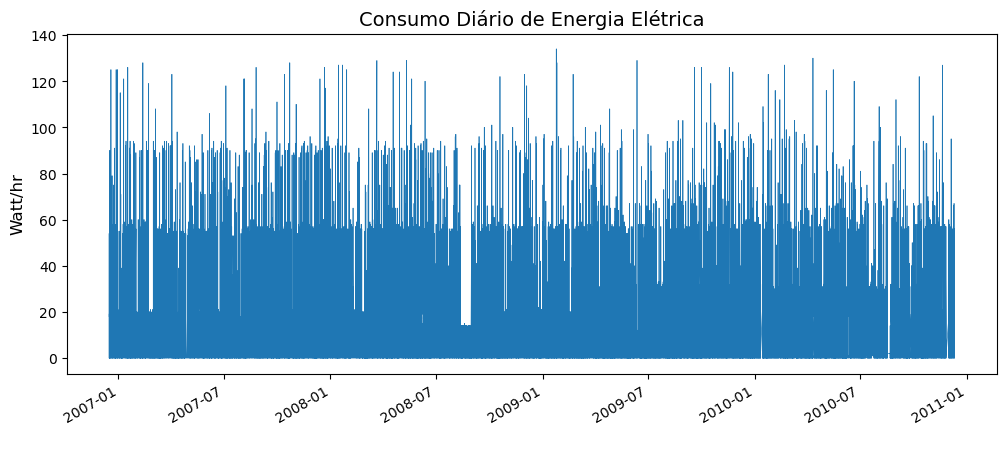

In [41]:
# Plot da série temporal

# Ajuste no tamanho do gráfico
fig, ax = plt.subplots(figsize=(12, 5))

# Define a métrica observada
df['total_consumo'].plot(linewidth=0.5)

# Define título
plt.title('Consumo Diário de Energia Elétrica', fontsize = 14)

# Define nomes dos eixos X e Y
plt.ylabel('Watt/hr', fontsize = 12)
plt.xlabel(' ', fontsize = 12)

No gráfico fica um pouco difícil analisar porque temos uma série de valores zerados, por conta disso será feito uma breve análise com a média dia de consumo. 

In [79]:
# Analise da média de consumo  por área da casa ao longo do período
# Para a análise foi selecionado Voltage e as medições por área da casa
# Para a escolha foi levado em consideração que os demais atributos de certa forma estão relacionados ao consumo global da casa
# sendo que para essa análise o ideal seria verificar com mais detalhes a base de dados

df_media = base[['Date', 'Voltage','Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'total_consumo']]

# Confere o numéro de linhas e colunas
df_media

,Date,Voltage,Sub_metering_1,Sub_metering_2,Sub_metering_3,total_consumo
0,2006-12-16,234.84,0.0,1.0,17.0,18.0
1,2006-12-16,233.63,0.0,1.0,16.0,17.0
2,2006-12-16,233.29,0.0,2.0,17.0,19.0
3,2006-12-16,233.74,0.0,1.0,17.0,18.0
4,2006-12-16,235.68,0.0,1.0,17.0,18.0
...,...,...,...,...,...,...
2075254,2010-11-26,240.43,0.0,0.0,0.0,0.0
2075255,2010-11-26,240.00,0.0,0.0,0.0,0.0
2075256,2010-11-26,239.82,0.0,0.0,0.0,0.0
2075257,2010-11-26,239.70,0.0,0.0,0.0,0.0


In [80]:
# Group by pela média do consumo diário
df_media = df_media.groupby(['Date'])[['Voltage','Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3','total_consumo']].mean()

# Confere o novo dataset
df_media

,Voltage,Sub_metering_1,Sub_metering_2,Sub_metering_3,total_consumo
Date,,,,,
2006-12-16,236.243763,0.000000,1.378788,12.439394,13.818182
2006-12-17,240.087028,1.411806,2.907639,9.264583,13.584028
2006-12-18,241.231694,0.738194,1.820139,9.734722,12.293056
2006-12-19,241.999313,0.582639,5.279167,4.303472,10.165278
2006-12-20,242.308062,0.000000,1.838889,9.765972,11.604861
...,...,...,...,...,...
2010-12-07,240.218646,1.197222,0.448611,4.475000,6.120833
2010-12-08,240.794931,0.000000,0.356944,2.765278,3.122222
2010-12-09,241.619722,1.253472,1.444444,6.174306,8.872222


In [81]:
# Converte o objeto em dataframe pandas
df_media = pd.DataFrame(df_media)
df_media

,Voltage,Sub_metering_1,Sub_metering_2,Sub_metering_3,total_consumo
Date,,,,,
2006-12-16,236.243763,0.000000,1.378788,12.439394,13.818182
2006-12-17,240.087028,1.411806,2.907639,9.264583,13.584028
2006-12-18,241.231694,0.738194,1.820139,9.734722,12.293056
2006-12-19,241.999313,0.582639,5.279167,4.303472,10.165278
2006-12-20,242.308062,0.000000,1.838889,9.765972,11.604861
...,...,...,...,...,...
2010-12-07,240.218646,1.197222,0.448611,4.475000,6.120833
2010-12-08,240.794931,0.000000,0.356944,2.765278,3.122222
2010-12-09,241.619722,1.253472,1.444444,6.174306,8.872222


In [82]:
# Reset do index para inclusão de colunas de tempo
df_media = df_media.reset_index()

# Confere dataset e número de linhas
df_media

,Date,Voltage,Sub_metering_1,Sub_metering_2,Sub_metering_3,total_consumo
0,2006-12-16,236.243763,0.000000,1.378788,12.439394,13.818182
1,2006-12-17,240.087028,1.411806,2.907639,9.264583,13.584028
2,2006-12-18,241.231694,0.738194,1.820139,9.734722,12.293056
3,2006-12-19,241.999313,0.582639,5.279167,4.303472,10.165278
4,2006-12-20,242.308062,0.000000,1.838889,9.765972,11.604861
...,...,...,...,...,...,...
1428,2010-12-07,240.218646,1.197222,0.448611,4.475000,6.120833
1429,2010-12-08,240.794931,0.000000,0.356944,2.765278,3.122222
1430,2010-12-09,241.619722,1.253472,1.444444,6.174306,8.872222
1431,2010-12-10,240.260674,0.766667,0.541667,6.813889,8.122222


In [83]:
# Cria variáveis para agrupamento de datas

# Variável Ano
df_media['year'] = df_media['Date'].dt.year

# Variável Mês
df_media['month'] = df_media['Date'].dt.month

#Variável Ano-Mês
df_media['month_year'] = df_media['Date'].dt.to_period('M')

In [85]:
# Data como index da base
df_media = df_media.set_index('Date')

# Confere o dataset
df_media

,Voltage,Sub_metering_1,Sub_metering_2,Sub_metering_3,total_consumo,year,month,month_year
Date,,,,,,,,
2006-12-16,236.243763,0.000000,1.378788,12.439394,13.818182,2006,12,2006-12
2006-12-17,240.087028,1.411806,2.907639,9.264583,13.584028,2006,12,2006-12
2006-12-18,241.231694,0.738194,1.820139,9.734722,12.293056,2006,12,2006-12
2006-12-19,241.999313,0.582639,5.279167,4.303472,10.165278,2006,12,2006-12
2006-12-20,242.308062,0.000000,1.838889,9.765972,11.604861,2006,12,2006-12
...,...,...,...,...,...,...,...,...
2010-12-07,240.218646,1.197222,0.448611,4.475000,6.120833,2010,12,2010-12
2010-12-08,240.794931,0.000000,0.356944,2.765278,3.122222,2010,12,2010-12
2010-12-09,241.619722,1.253472,1.444444,6.174306,8.872222,2010,12,2010-12


Text(0.5, 0, ' ')

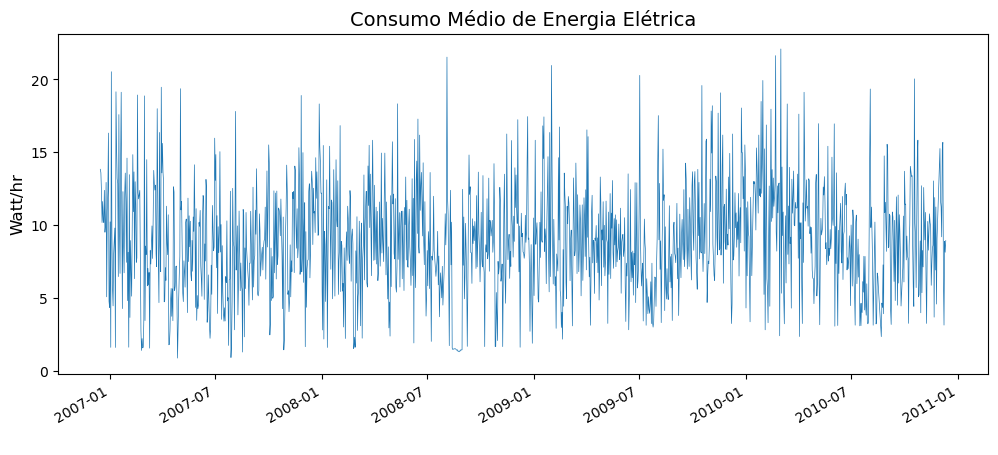

In [86]:
# Plot da série temporal

# Ajuste no tamanho do gráfico
fig, ax = plt.subplots(figsize=(12, 5))

# Define a métrica observada
df_media['total_consumo'].plot(linewidth=0.5)

# Define título
plt.title('Consumo Médio de Energia Elétrica', fontsize = 14)

# Define nomes dos eixos X e Y
plt.ylabel('Watt/hr', fontsize = 12)
plt.xlabel(' ', fontsize = 12)

No gráfico com a média de consumo diário, é possível observar que o consumo mantém o mesmo nível ao longo dos anos. Nos meses de Julho temos uma queda no consumo, talvez pelo fato de ser férias e os moradores ficarem em outros lugares e após esse mês vemos uma alta no consumo de energia elétrica. 

Vale lembrar que as medições foram feitas na Europa, mais precisamente na França. Por conta da localização precisamos levar em considerar as estações, com temperaturas mais baixas a partir de dezembro e temperaturas mais altas a partir de julho. Esse aumento no consumo no final do ano pode estar relacionado ao aquecedor da casa.

Text(0, 0.5, 'total_consumo')

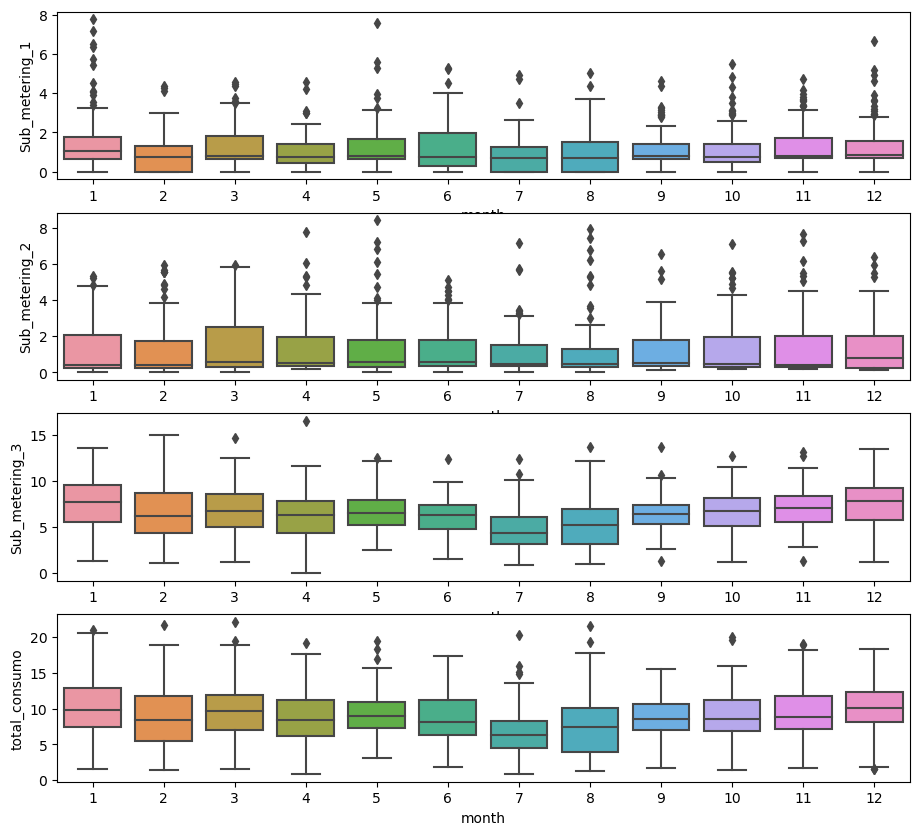

In [87]:
# Boxplot dos dados
# Ajuste no tamanho do gráfico
fig, axes = plt.subplots(4, 1, figsize=(11, 10), sharex=False)

# Plot com 3 variáveis
for name, ax in zip(['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'total_consumo'], axes):

    sns.boxplot(data=df_media, x='month', y = name, ax = ax)

# Configura o eixo Y    
ax.set_ylabel(name)

Na análise por setor da casa, o maior impacto é o Sub_metering_3 que é justamente as medições de aquecedor e ar condicionado na casa. Fica bem claro que no mês de julho o consumo tem uma queda com um aumento longo em agosto. 

Pelo boxplot, a base de dados possui um muito outliers quando analisado pela média de consumo diário.

Text(0.5, 0, ' ')

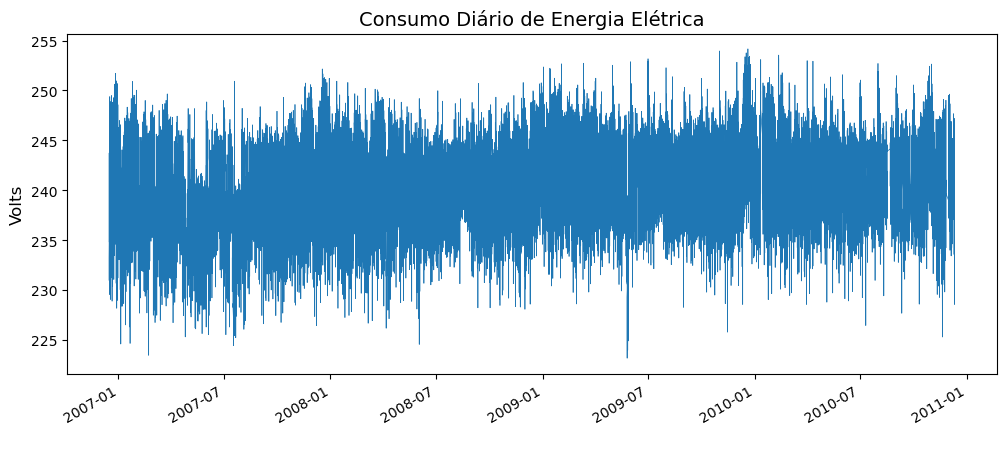

In [88]:
# Plot da série temporal

# Ajuste no tamanho do gráfico
fig, ax = plt.subplots(figsize=(12, 5))

# Define a métrica observada
df['Voltage'].plot(linewidth=0.5)

# Define título
plt.title('Consumo Diário de Energia Elétrica', fontsize = 14)

# Define nomes dos eixos X e Y
plt.ylabel('Volts', fontsize = 12)
plt.xlabel(' ', fontsize = 12)